# Unbox the Cox: Why perfect predictors result in large p-values (0.9) ?

## A hidden dark secret of Cox regression

If you have been following previous blog posts, you might recall that logistic regression encounters a problem when trying to fit perfectly separated data, leading to an infinite odds ratio ($\beta$). In Cox regression, where hazard replaces odds, you might wonder if a similar issue arises with perfect predictors. It does occur, but unlike logistic regression, it is much less apparent how this occurs here and even what consistutes "perfect predictors".

In Cox regression, perfect predictors are predictors ($x$) whose ranks exactly match the ranks of event times (Spearman correlation = 1). In a previous section, we introduced a made-up dataset with five subjects, where a single predictor, $x$, represented the dosage of a life-extending drug. To make $x$ a perfect predictor of event times, here we swapped the event times for subjects C and D:

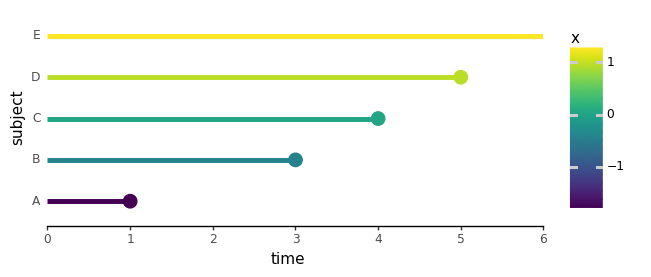

<ggplot: (8773484071400)>

In [39]:
import numpy as np
import pandas as pd
import plotnine as p9

from cox.plots import (
    plot_subject_event_times,
    animate_subject_event_times_and_mark_at_risk,
    plot_cost_vs_beta,
)

perfect_df =  pd.DataFrame({
    'subject': ['A', 'B', 'C', 'D', 'E'],
    'time': [1, 3, 4, 5, 6],
    'event': [1, 1, 1, 1, 0],
    'x': [-1.7, -0.4, 0.0, 0.9, 1.2],
})

plot_subject_event_times(perfect_df, color_map='x')

To understand why these "perfect predictors" can be problematic, let's pick up where we left off and check the negative log-likelihood cost plotted against $\beta$:

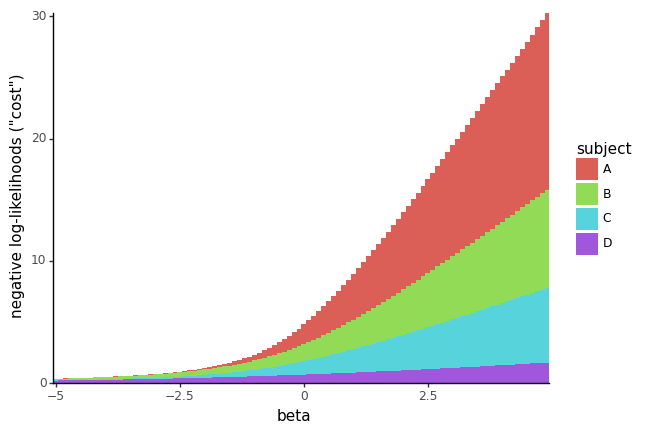

<ggplot: (8773484071415)>

In [40]:
def event_time_and_x_from_subject(df, subject):
    subject_with_event_df = df.query(f"subject == '{subject}' & event == 1")
    if subject_with_event_df.empty: # For censored subjects return infinite time
        return (np.inf, 0)
    return subject_with_event_df.iloc[0][['time', 'x']]

def subjects_at_risk_data(df, subject):
    time = event_time_and_x_from_subject(df, subject)[0]
    return df.query(f'time >= {time}')

def log_likelihood(df, subject, beta):
    x_subjects_at_risk = subjects_at_risk_data(df, subject)['x']
    x_subject = event_time_and_x_from_subject(df, subject)[1]
    at_risk_hazards = np.exp(beta * x_subjects_at_risk)
    return beta * x_subject - np.log(np.sum(at_risk_hazards))

def neg_log_likelihood_for_all_subjects(df, beta):
    subjects = df.query("event == 1")['subject'].tolist()
    neg_log_likelihoods = [-log_likelihood(df, subject, beta) for subject in subjects]
    return pd.DataFrame({
        'subject': subjects,
        'neg_log_likelihood': neg_log_likelihoods
    })

def neg_log_likelihood_all_subjects_sweep_betas(df, betas=np.arange(-5, 5, 0.1)):
    loglikelihoods_per_beta = []
    for beta in betas:
        beta_df = neg_log_likelihood_for_all_subjects(df, beta)
        beta_df.insert(0, 'beta', beta) # Add beta column
        loglikelihoods_per_beta.append(beta_df)
    return pd.concat(loglikelihoods_per_beta)

negloglik_sweep_betas_perfect_df = neg_log_likelihood_all_subjects_sweep_betas(
    perfect_df,
    betas=np.arange(-5, 5, 0.1)
)
plot_cost_vs_beta(negloglik_sweep_betas_perfect_df, width=0.1)

You can see right away that there is no minimum value of $\beta$ any longer: if we use very large negative values of $\beta$, we end up with log-likelihood fits that are near-perfect for all events.

Now, let's dive into the math behind this and take a look at the likelihood of event A. We'll dig into how the numerator and denominator change as we tweak $\beta$:

$$L_A = \frac{h_A}{h_A + h_B + h_C + h_D + h_E} = \frac{e^{-1.7\beta}}{e^{-1.7\beta} + e^{-0.4\beta} + e^{0\beta} + e^{0.9\beta} + e^{1.2\beta}}$$

When $\beta$ is high or a large positive number, the last term in the denominator (with the largest $x$ of 1.2), representing the hazard of subject E, dominates the entire denominator and becomes exceedingly large. So, the likelihood becomes small and approaches zero:

$$L_A (\mathrm{large\ positive\ \beta}) \approx \frac{e^{-1.7\beta}}{e^{1.2\beta}} = e^{(-1.7 + 1.2)\beta} = e^{-0.5\beta} \rightarrow 0$$

This results in a big negative log-likelihood. The same thing happens for each individual likelihood because the last hazard of subject E, will always exceed any hazard in the numerator. As a result, the negative log-likelihood increases for subjects A to D. In this case, when we have high $\beta$, it brings down all the likelihoods, resulting in poor fits for all events. 

Now, when $\beta$ is low or a big negative number, the first term in the denominator, representing the hazard of subject A, dominates since it has the lowest $x$ value. As the same hazard of subject A also appears in the numerator, the likelihood $L_A$ can be arbitrarily close to 1 by making $\beta$ increasingly negative, thereby creating an almost perfect fit:

$$L_A (\mathrm{large\ negative\ \beta}) \approx \frac{e^{-1.7\beta}}{e^{-1.7\beta}} = 1$$

The same deal goes for all the other individual likelihoods: negative $\beta$ s now boost the likelihoods of all events at the same time. Basically, having a negative $\beta$ doesn't come with any downsides. At the same time, certain individual hazards increase (subjects A and B with negative $x$), some stay the same (subject C with $x = 0$), and others decrease (subject D with positive $x$). But remember, the absolute values of $x$ don't really matter here - we're working with likelihoods, which are just ratios of hazards. We can verify this math hand-waving by plotting individual hazards:

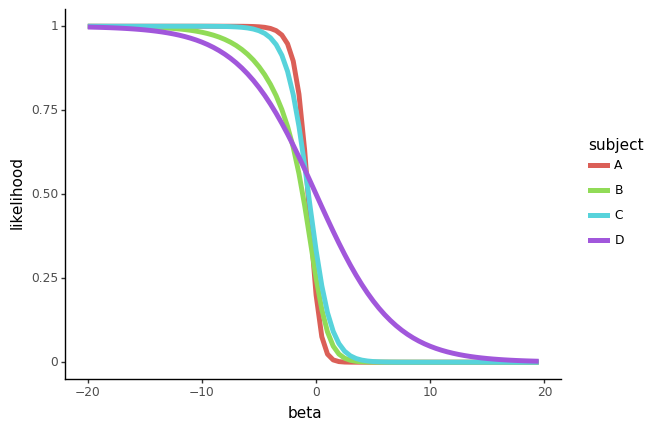

<ggplot: (8773481809619)>

In [41]:
def plot_likelihoods(df, ylim=[-20, 20]):
    betas = np.arange(ylim[0], ylim[1], 0.5)
    subjects = df.query("event == 1")['subject'].tolist()
    likelihoods_per_subject = []
    for subject in subjects:
        likelihoods = [
            np.exp(log_likelihood(df, subject, beta))
            for beta in betas
        ]
        likelihoods_per_subject.append(
            pd.DataFrame({
                'beta': betas,
                'likelihood': likelihoods,
                'subject': [subject] * len(betas),
            })        
        )
    lik_df = pd.concat(likelihoods_per_subject)
    return (
        p9.ggplot(lik_df, p9.aes('beta', 'likelihood', color='subject'))
        + p9.geom_line(size=2)
        + p9.theme_classic()
    )    

plot_likelihoods(perfect_df)

The way likelihoods are put together, as a ratio of a hazard to the sum of hazards of all subjects still at risk, means that negative $\beta$ values make a perfect fit for the likelihood of each subject whose event time rank is greater than or equal to the predictor rank! As a side note, $x$ had a perfect _negative_ Spearman correlation with event times, things would be flipped around: arbitrarily positive $\beta$ s would give us insanely good fits.

## Mis-aligned predictor and time ranks

We can actually see this and show you what goes down when event time ranks and predictor ranks do not line up using a another made-up example:

In [42]:
sample_df = pd.DataFrame({
    'subject': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'],
    'x': [-1.7, -0.4, 0.0, 0.5, 0.9, 1.2, 1.3, 1.45],
    'time': [1, 2, 4, 3, 5, 7, 6, 8],
    'rank_x': [1, 2, 3, 4, 5, 6, 7, 8],
    'event': [1, 1, 1, 1, 1, 1, 1, 0],
})

sample_df

,subject,x,time,rank_x,event
0,A,-1.70,1,1,1
1,B,-0.40,2,2,1
2,C,0.00,4,3,1
3,D,0.50,3,4,1
4,E,0.90,5,5,1
5,F,1.20,7,6,1
6,G,1.30,6,7,1
7,H,1.45,8,8,0


In this particular example, the `time` column ranges from 1 to 8, where each value represents its own rank. We also have an `x_rank` column, which ranks the predictors $x$. Now, here's the key observation: for subjects D and G, their `x_rank` is actually higher than their corresponding `time` rank. As a result, the likelihoods of D and G won't experience the cancellation effect between the numerator and denominator when we have large negative values of $\beta$:

$$L_D = \frac{h_D}{h_C + h_D + \cdots + h_H} = \frac{e^{0.5\beta}}{e^{0\beta} + e^{0.5\beta} + \cdots + e^{1.45\beta}}$$

$$L_D (\mathrm{large\ negative\ \beta}) \approx \frac{e^{0.5\beta}}{e^{0\beta}} = e^{0.5\beta} \rightarrow 0$$

 Their likelihoods are now maximal at some intermediate finite values of $\beta$. Let's take a look at a plot of individual likelihoods to see this:

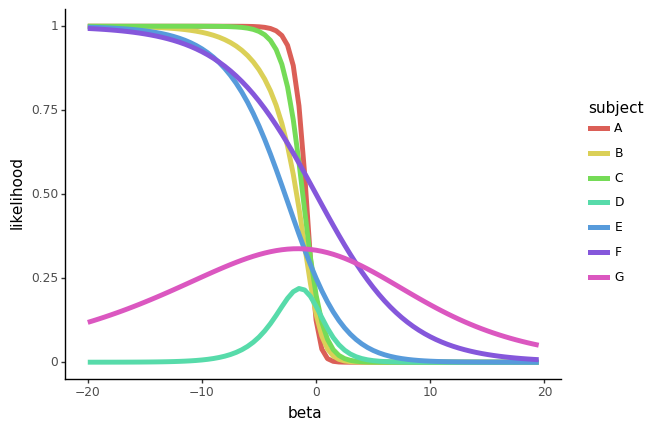

<ggplot: (8773481773559)>

In [43]:
plot_likelihoods(sample_df)

These "mis-aligned" ranks between a time and a predictor play a crucial role: they stop all likelihoods from essentially collapsing into one when we have significantly negative $\beta$ values.

In conclusion, in Cox regression, in order to obtain a finite coefficient $\beta$ for a predictor $x$, we require at least one instance where the rank of the predictor $x$ is lower than the rank of the event time.

## Perfect is indeed the enemy of the good (p-value)

So, how do these perfect predictors actually behave in real-life scenarios? Well, to find out, let's once again turn to the lifelines library for some investigation:

In [44]:
from lifelines import CoxPHFitter

perfect_cox_model = CoxPHFitter()
perfect_cox_model.fit(perfect_df, duration_col='time', event_col='event', formula='x')
perfect_cox_model.print_summary()

/home/igor/.cache/pypoetry/virtualenvs/blog--v8k-B20-py3.8/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py:1586: ConvergenceWarning: The log-likelihood is getting suspiciously close to 0 and the delta is still large. There may be complete separation in the dataset. This may result in incorrect inference of coefficients. See https://stats.stackexchange.com/q/11109/11867 for more.

/home/igor/.cache/pypoetry/virtualenvs/blog--v8k-B20-py3.8/lib/python3.8/site-packages/lifelines/utils/__init__.py:1165: ConvergenceWarning: Column x has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression

/home/igor/.cache/pypoetry/virtualenvs/blog--v8k-B20-py3.8/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see th

<lifelines.CoxPHFitter: fitted with 5 total observations, 1 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 5
number of events observed = 4
   partial log-likelihood = -0.00
         time fit was run = 2023-06-24 16:07:39 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
x         -31.95       0.00     388.11          -792.62           728.73                 0.00                  inf

            cmp to     z    p   -log2(p)
covariate                               
x             0.00 -0.08 0.93       0.10
---
Concordance = 1.00
Partial AIC = 2.00
log-likelihood ratio test = 9.57 on 1 df
-log2(p) of ll-ratio test = 8.99

Just like in logistic regression, we're encountering convergence warnings and getting extremely wide confidence intervals for our predictor coefficient $\beta$. As a result, we end up with a p-value of **0.93**! If we simply filter models based on p-values without taking this issue into account or conducting further investigation, we would overlook these perfect predictors.

To tackle this convergence problem, the lifelines library documentation and some helpful StackOverflow threads suggest a potential solution: incorporating a regularization term into the cost function. This term effectively increases the cost for large coefficient values, and you can activate L2 regularization by setting the `penalizer` argument to a value greater than zero:

In [45]:
perfect_pen_cox_model = CoxPHFitter(penalizer=0.01, l1_ratio=0)
perfect_pen_cox_model.fit(perfect_df, duration_col='time', event_col='event', formula='x')
perfect_pen_cox_model.print_summary()

<lifelines.CoxPHFitter: fitted with 5 total observations, 1 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.01
                 l1 ratio = 0
      baseline estimation = breslow
   number of observations = 5
number of events observed = 4
   partial log-likelihood = -1.01
         time fit was run = 2023-06-24 16:07:39 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
x          -3.56       0.03       2.25            -7.97             0.85                 0.00                 2.35

            cmp to     z    p   -log2(p)
covariate                               
x             0.00 -1.58 0.11       3.13
---
Concordance = 1.00
Partial AIC = 4.01
log-likelihood ratio test = 7.56 on 1 df
-log2(p) of ll-ratio test = 7.39

This approach fixes the convergence warning, but it doesn't really make a big dent in shrinking those pesky confidence intervals and the resulting p-values. Even with this regularization trick, the p-value for a perfect predictor still hangs around at a somewhat large value 0.11.

## Time is relative: only ranks matter

Lastly, we'll verify that the absolute values of event times have no impact on a Cox regression fit, using our previous example. To do this, we'll introduce a new column called `time2`, which will contain random numbers in the same order as the `time` column:

In [46]:
sample_df = pd.DataFrame({
    'subject': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'],
    'x': [-1.7, -0.4, 0.0, 0.5, 0.9, 1.2, 1.3, 1.45],
    'time': [1, 2, 4, 3, 5, 7, 6, 8],
    'rank_x': [1, 2, 3, 4, 5, 6, 7, 8],
    'event': [1, 1, 1, 1, 1, 1, 1, 0],
}).sort_values('time')

np.random.seed(42)
sample_df['time2'] = sorted(np.random.randint(low=-42, high=888, size=8))
sample_df

,subject,x,time,rank_x,event,time2
0,A,-1.70,1,1,1,-22
1,B,-0.40,2,2,1,29
3,D,0.50,3,4,1,60
2,C,0.00,4,3,1,64
4,E,0.90,5,5,1,228
6,G,1.30,6,7,1,393
5,F,1.20,7,6,1,658
7,H,1.45,8,8,0,818


Their fits are indeed indentical:

In [47]:
sample_cox_model = CoxPHFitter()
sample_cox_model.fit(sample_df, duration_col='time', event_col='event', formula='x')
sample_cox_model.print_summary()

<lifelines.CoxPHFitter: fitted with 8 total observations, 1 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 8
number of events observed = 7
   partial log-likelihood = -4.32
         time fit was run = 2023-06-24 16:07:39 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
x          -3.74       0.02       1.91            -7.49             0.01                 0.00                 1.01

            cmp to     z    p   -log2(p)
covariate                               
x             0.00 -1.95 0.05       4.30
---
Concordance = 0.93
Partial AIC = 10.65
log-likelihood ratio test = 12.56 on 1 df
-log2(p) of ll-ratio test = 11.31

In [48]:
sample_cox_model.fit(sample_df, duration_col='time2', event_col='event', formula='x')
sample_cox_model.print_summary()

<lifelines.CoxPHFitter: fitted with 8 total observations, 1 right-censored observations>
             duration col = 'time2'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 8
number of events observed = 7
   partial log-likelihood = -4.32
         time fit was run = 2023-06-24 16:07:39 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
x          -3.74       0.02       1.91            -7.49             0.01                 0.00                 1.01

            cmp to     z    p   -log2(p)
covariate                               
x             0.00 -1.95 0.05       4.30
---
Concordance = 0.93
Partial AIC = 10.65
log-likelihood ratio test = 12.56 on 1 df
-log2(p) of ll-ratio test = 11.31

## Conclusion

What did we learn from all of this?

- Perfect predictors in survival models are those predictors whose ranks perfectly match the ranks of event times.
- Cox regression cannot fit these perfect predictors with a finite coefficient $\beta$, leading to wide confidence intervals and big p-values.
- The actual values of event times don't really matter - it's all about their ranks.
- When the ranks of event times and predictors don't align, we don't get that handy cancellation effect for large $\beta$ values in likelihoods. So, we need at least one case where the ranks don't match to have a fit with a finite coefficient.
- Even if we try some fancy regularization techniques, perfect predictors can still give us those annoyingly wide confidence intervals and high p-values in real-life situations.
- Just like in logistic regression, if we don't really care about those p-values, using a regularization method can still provide us with a handy model fit that gets the prediction right!